In [ ]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from pandas import Series
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import data**



In [ ]:
train = pd.read_csv('/content/drive/MyDrive/thesis/dataset and ipynb/trainset.csv')
test = pd.read_csv('/content/drive/MyDrive/thesis/dataset and ipynb/testset.csv')

train = train.iloc[:,1:]
test = test.iloc[:-2,:]

train=train.drop(['sku'], axis=1)
test=test.drop(['sku'], axis=1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Feature converting**

Convert all yes/no data into 1/0

In [ ]:
# For trainset

train['went_on_backorder']=train['went_on_backorder'].map( {'No': 0, 'Yes': 1} ).astype(int)
train['potential_issue']=train['potential_issue'].map( {'No': 0, 'Yes': 1} ).astype(int)
train['deck_risk']=train['deck_risk'].map( {'No': 0, 'Yes': 1} ).astype(int)
train['oe_constraint']=train['oe_constraint'].map( {'No': 0, 'Yes': 1} ).astype(int)
train['ppap_risk']=train['ppap_risk'].map( {'No': 0, 'Yes': 1} ).astype(int)
train['stop_auto_buy']=train['stop_auto_buy'].map( {'No': 0, 'Yes': 1} ).astype(int)
train['rev_stop']=train['rev_stop'].map( {'No': 0, 'Yes': 1} ).astype(int)

# For testset

test['went_on_backorder']=test['went_on_backorder'].map( {'No': 0, 'Yes': 1} ).astype(int)
test['potential_issue']=test['potential_issue'].map( {'No': 0, 'Yes': 1} ).astype(int)
test['deck_risk']=test['deck_risk'].map( {'No': 0, 'Yes': 1} ).astype(int)
test['oe_constraint']=test['oe_constraint'].map( {'No': 0, 'Yes': 1} ).astype(int)
test['ppap_risk']=test['ppap_risk'].map( {'No': 0, 'Yes': 1} ).astype(int)
test['stop_auto_buy']=test['stop_auto_buy'].map( {'No': 0, 'Yes': 1} ).astype(int)
test['rev_stop']=test['rev_stop'].map( {'No': 0, 'Yes': 1} ).astype(int)


Convert -99 in "perf_6_month_avg","perf_12_month_avg" to NA)*

In [ ]:
train['perf_6_month_avg']=train['perf_6_month_avg'].replace(-99, np.NaN)
train['perf_12_month_avg']=train['perf_12_month_avg'].replace(-99, np.NaN)

test['perf_6_month_avg']=test['perf_6_month_avg'].replace(-99, np.NaN)
test['perf_12_month_avg']=test['perf_12_month_avg'].replace(-99, np.NaN)

Convert pieces_past_due and local_bo_qty to categorical features

In [ ]:
train["pieces_past_due"]=train["pieces_past_due"].astype(bool).astype(int)
train["local_bo_qty"]=train["local_bo_qty"].astype(bool).astype(int)

test["pieces_past_due"]=test["pieces_past_due"].astype(bool).astype(int)
test["local_bo_qty"]=test["local_bo_qty"].astype(bool).astype(int)

**Normalization**

In [ ]:
# For trainset
scaler = MinMaxScaler(feature_range=(0, 1))
names = train.columns
df1 = scaler.fit_transform(train)
scaled_train = pd.DataFrame(df1, columns=names)

# For testset
df2 = scaler.fit_transform(test)
scaled_test = pd.DataFrame(df2, columns=names)

**Train set sampling (20%)**

In [ ]:
scaled_train = scaled_train.sample(frac=0.2)

**Missing data imputation and evaluation (including median, knn, deletion)**

In [ ]:
# Check missing values by features

percent_missing = scaled_train.isnull().sum() * 100 / len(scaled_train)
percent_missing 

national_inv         0.000000
lead_time            5.963172
in_transit_qty       0.000000
forecast_3_month     0.000000
forecast_6_month     0.000000
forecast_9_month     0.000000
sales_1_month        0.000000
sales_3_month        0.000000
sales_6_month        0.000000
sales_9_month        0.000000
min_bank             0.000000
potential_issue      0.000000
pieces_past_due      0.000000
perf_6_month_avg     7.621781
perf_12_month_avg    7.187800
local_bo_qty         0.000000
deck_risk            0.000000
oe_constraint        0.000000
ppap_risk            0.000000
stop_auto_buy        0.000000
rev_stop             0.000000
went_on_backorder    0.000000
dtype: float64

**Process train set with combined missing value imputation + imbalanced data pre-processing，and random forest baseline evaluation**

In [ ]:
sub_train = scaled_train.copy()

In [ ]:
# 1. kNN x SMOTE, takes 24 minutes

# knn part

train_mix_1 = sub_train.copy()

imputer = KNNImputer(n_neighbors=3)

imputed = imputer.fit_transform(train_mix_1)

train_mix_1_imputed = pd.DataFrame(imputed, columns=train_mix_1.columns)

# split

X = train_mix_1_imputed.drop(['went_on_backorder'], axis = 1) # everything except backorder
Y = train_mix_1_imputed['went_on_backorder'] # only backorder

# SMOTE part

oversampler = SMOTE(random_state = 0)
X, Y = oversampler.fit_resample(X, Y)

# Validation

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.1, random_state = 0)

RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

Y_pred = RF.predict(X_validation)
print("Random Forest Classifier report \n", classification_report(Y_validation, Y_pred))

Random Forest Classifier report 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     33404
         1.0       0.99      0.99      0.99     33649

    accuracy                           0.99     67053
   macro avg       0.99      0.99      0.99     67053
weighted avg       0.99      0.99      0.99     67053



In [ ]:
# 2. kNN x RUS, takes 26 minutes

# knn part

train_mix_2 = sub_train.copy()

imputer = KNNImputer(n_neighbors=3)

imputed = imputer.fit_transform(train_mix_2)

train_mix_2_imputed = pd.DataFrame(imputed, columns=train_mix_2.columns)

# split

X = train_mix_2_imputed.drop(['went_on_backorder'], axis = 1) # everything except backorder
Y = train_mix_2_imputed['went_on_backorder'] # only backorder

# RUS part

undersampler = RandomUnderSampler(random_state = 0)
X, Y = undersampler.fit_resample(X, Y)

# Validation

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.1, random_state = 0)

RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

Y_pred = RF.predict(X_validation)
print("Random Forest Classifier report \n", classification_report(Y_validation, Y_pred))

Random Forest Classifier report 
               precision    recall  f1-score   support

         0.0       0.90      0.81      0.85       209
         1.0       0.84      0.92      0.88       231

    accuracy                           0.87       440
   macro avg       0.87      0.86      0.86       440
weighted avg       0.87      0.87      0.87       440



In [ ]:
# 3. Deletion x SMOTE, takes 4 minutes

# deletion part

train_mix_3 = sub_train.copy()

train_mix_3.dropna(axis='index', inplace=True)

# split

X = train_mix_3.drop(['went_on_backorder'], axis = 1) # everything except backorder
Y = train_mix_3['went_on_backorder'] # only backorder

# SMOTE part

oversampler = SMOTE(random_state = 0)
X, Y = oversampler.fit_resample(X, Y)

# Validation

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.1, random_state = 0)

RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

Y_pred = RF.predict(X_validation)
print("Random Forest Classifier report \n", classification_report(Y_validation, Y_pred))

Random Forest Classifier report 
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     30751
         1.0       0.99      1.00      0.99     31155

    accuracy                           0.99     61906
   macro avg       0.99      0.99      0.99     61906
weighted avg       0.99      0.99      0.99     61906



In [ ]:
# 4. Deletion x RUS, takes 1 minutes

# deletion part

train_mix_4 = sub_train.copy()

train_mix_4.dropna(axis='index', inplace=True)

# split

X = train_mix_4.drop(['went_on_backorder'], axis = 1) # everything except backorder
Y = train_mix_4['went_on_backorder'] # only backorder

# RUS part

undersampler = RandomUnderSampler(random_state = 0)
X, Y = undersampler.fit_resample(X, Y)

# Validation

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.1, random_state = 0)

RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

Y_pred = RF.predict(X_validation)
print("Random Forest Classifier report \n", classification_report(Y_validation, Y_pred))

Random Forest Classifier report 
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.88       209
         1.0       0.90      0.89      0.89       233

    accuracy                           0.89       442
   macro avg       0.89      0.89      0.89       442
weighted avg       0.89      0.89      0.89       442



**Hyperparameter tuning**


In [ ]:
# Prepare the selected trainset
# missing value: deletion
# imbalance: SMOTE

train = scaled_train.copy()

train.dropna(axis='index', inplace=True)

X = train.drop(['went_on_backorder'], axis = 1) # everything except backorder
Y = train['went_on_backorder'] # only backorder

oversampler = SMOTE(random_state = 0)
X, Y = oversampler.fit_resample(X, Y)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.1, random_state = 0) 

In [ ]:
# XGB tuning
parameterset = {'n_estimators': [10,50,100,200],  
        'learning_rate': [0.01, 0.05, 0.1,0.5]} 

gridXGB = GridSearchCV(XGBClassifier(),parameterset,cv=5,scoring = 'precision') 
gridXGB.fit(X_train,Y_train.iloc[:,0])

tableXGB = pd.DataFrame(gridXGB.cv_results_)
tableXGB

In [ ]:
# LGB tuning
parameterset = {'n_estimators': [10,50,100,200],  
        'learning_rate': [0.01, 0.05, 0.1,0.5]} 

gridLGB = GridSearchCV(LGBMClassifier(),parameterset,cv=5,scoring = 'precision') 
gridLGB.fit(X_train,Y_train.iloc[:,0])

tableLGB = pd.DataFrame(gridLGB.cv_results_)
tableLGB

In [ ]:
# LR tuning

parameterset = {'penalty': ["l2"],  
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'C' :[100, 10, 1.0, 0.1, 0.01],
        'max_iter':[100000]} 

gridlr = GridSearchCV(LogisticRegression(),parameterset,cv=5,scoring = 'precision') 
gridlr.fit(X_train,Y_train.iloc[:,0]) 

tableLR = pd.DataFrame(gridlr.cv_results_)
tableLR

In [ ]:
# RF tuning

parameterset = {'n_estimators': [25,50,75,100],  
        'max_depth': [5,6,7,8,9]} 

gridrf = GridSearchCV(RandomForestClassifier(),parameterset,cv=5,scoring = 'precision') 
gridrf.fit(X_train,Y_train.iloc[:,0]) 

tableRF = pd.DataFrame(gridrf.cv_results_)
print(tableRF)

## Model Selection

In [ ]:
# train set

train = scaled_train.copy()

train.dropna(axis='index', inplace=True)

X = train.drop(['went_on_backorder'], axis = 1) # everything except backorder
Y = train['went_on_backorder'] # only backorder

from imblearn.over_sampling import SMOTE # 6s
oversampler = SMOTE(random_state = 0)
X, Y = oversampler.fit_resample(X, Y)

In [ ]:
# test set

scaled_test = pd.read_csv('/content/drive/MyDrive/thesis/dataset and ipynb/11_21_test.csv')
scaled_test = scaled_test.iloc[:,1:]

test = scaled_test.copy()

test.dropna(axis='index', inplace=True)

In [ ]:
Y_validation = test.drop(['went_on_backorder'], axis = 1)
Y_test = test['went_on_backorder'] 

In [ ]:
# Random forest

RF = RandomForestClassifier(n_estimators=25, max_depth=9, random_state=0)
RF.fit(X,Y)

Y_pred = RF.predict(Y_validation)
print("Random Forest Classifier report \n", classification_report(Y_test, Y_pred))

Random Forest Classifier report 
               precision    recall  f1-score   support

         0.0       0.99      0.78      0.87    220409
         1.0       0.03      0.49      0.05      2564

    accuracy                           0.78    222973
   macro avg       0.51      0.63      0.46    222973
weighted avg       0.98      0.78      0.87    222973



Text(0.5, 15.0, 'Predicted label')

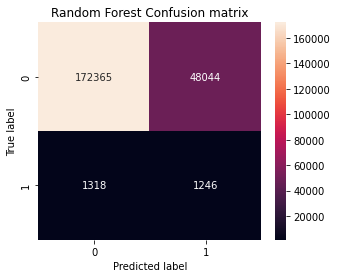

In [ ]:
# confusion matrix

plt.figure(figsize = (5,4))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot = True,fmt='g')
plt.title('Random Forest Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
# Logistic Regression

LR = LogisticRegression(penalty="l2",C=0.01, solver="liblinear",random_state=0)
LR.fit(X,Y)

Y_pred = LR.predict(Y_validation)
print("Random Forest Classifier report \n", classification_report(Y_test, Y_pred))

Random Forest Classifier report 
               precision    recall  f1-score   support

         0.0       0.99      0.75      0.85    220409
         1.0       0.02      0.41      0.04      2564

    accuracy                           0.75    222973
   macro avg       0.50      0.58      0.45    222973
weighted avg       0.98      0.75      0.85    222973



Text(0.5, 15.0, 'Predicted label')

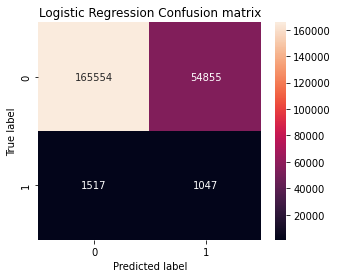

In [ ]:
# confusion matrix

plt.figure(figsize = (5,4))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot = True,fmt='g')
plt.title('Logistic Regression Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
# XGB
XGB = XGBClassifier(n_estimators =100, learning_rate =0.5,random_state=0)
XGB.fit(X,Y)

Y_pred = XGB.predict(Y_validation)
print("Random Forest Classifier report \n", classification_report(Y_test, Y_pred))

Random Forest Classifier report 
               precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    220409
         1.0       0.04      0.44      0.08      2564

    accuracy                           0.88    222973
   macro avg       0.52      0.66      0.50    222973
weighted avg       0.98      0.88      0.92    222973



Text(0.5, 15.0, 'Predicted label')

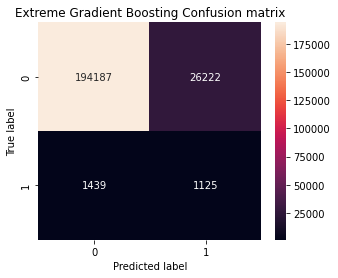

In [ ]:
# confusion matrix

plt.figure(figsize = (5,4))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot = True,fmt='g')
plt.title('Extreme Gradient Boosting Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
# LGB

LGB = LGBMClassifier(n_estimators =100, learning_rate =0.5,random_state=0)
LGB.fit(X,Y)

Y_pred = LGB.predict(Y_validation)
print("Random Forest Classifier report \n", classification_report(Y_test, Y_pred))

Random Forest Classifier report 
               precision    recall  f1-score   support

         0.0       1.00      0.63      0.77    220409
         1.0       0.02      0.76      0.04      2564

    accuracy                           0.63    222973
   macro avg       0.51      0.69      0.41    222973
weighted avg       0.98      0.63      0.76    222973



Text(0.5, 15.0, 'Predicted label')

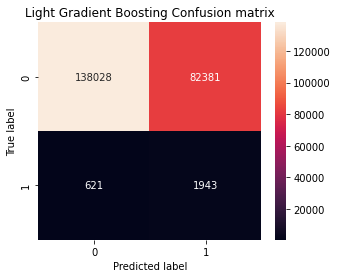

In [ ]:
# confusion matrix

plt.figure(figsize = (5,4))
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot = True,fmt='g')
plt.title('Light Gradient Boosting Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
# ROC-AUC graph for all models

classifiers = [RandomForestClassifier(n_estimators=25, max_depth=9, random_state=0),  
               LogisticRegression(penalty="l2",C=0.01, solver="liblinear",random_state=0), 
               XGBClassifier(n_estimators =100, learning_rate =0.5,random_state=0),
               LGBMClassifier(n_estimators =100, learning_rate =0.5,random_state=0)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X, Y)
    yproba = model.predict(Y_validation)
    
    fpr, tpr, _ = roc_curve(Y_test,  yproba)
    auc = roc_auc_score(Y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

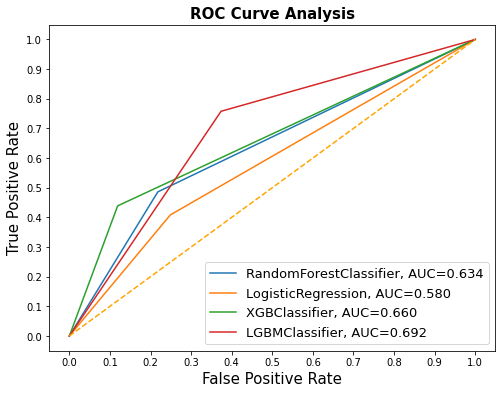

In [ ]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()